# Benchmarking Annotation Storage
Click to open in: [[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/tree/master/benchmarks/annotation_store.ipynb)][[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/master/benchmarks/annotation_store.ipynb)][[Kaggle](https://kaggle.com/kernels/welcome?src=https://github.com/TissueImageAnalytics/tiatoolbox/blob/master/benchmarks/annotation_store.ipynb)]

_In order to run this notebook on a Kaggle platform, 1) click the Kaggle URL 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About This Notebook

Managing annotation, either created by hand or from model output, is a
common task in computational pathology. For a small number of
annotations this may be trivial. However, for large numbers of
annotations, it is often necessary to store the annotations in a more
structured format such as a database. This is because finding a desired
subset of annotations within a very large collection, for example over
one million cell boundary polygons derived from running HoVerNet on a
WSI, may be very slow if performed in a naive manner. In the toolbox we
implement two storage method to make handling annotations easier:
`DictionaryStore` and `SQLiteStore`.

### Storage Classes

Both stores act as a key-value store where the key is the annotation ID
(as a string) and the value is the annotation. This follows the Python
[`MutableMapping`](https://docs.python.org/3/library/collections.abc.html#collections.abc.MutableMapping)
interface meaning that the stores can be used in the same way as a
regular Python dictionary (`dict`).

The `DictionaryStore` is implemented internally using a Python
dictionary. It is a realtively simple class, operating with all
annotations in memory and using a simple scan method to search for
annotations. This works very well for a small number of annotations. In
contrast the `SQLiteStore` is implemented using a SQLite database
(either in memory or on disk), it is a more complex class making use of
an rtree index to efficiently spatially search for annotations. This is
much more suited to a very large number of annotations. However, they
both follow the same interface and can be used interchangeably for
almost all methods (`SQLiteStore` has some additional methods).

### Provided Functionality (Mini Tutorial)

The storage classes provide a lot of functionality including. This
includes all of the standard `MutableMapping` methods, as well as
some additional ones for querying the collection of annotations.
Below is a brief summary of the main functionality.

#### Adding Annotations

```python
from tiatoolbox.annotation.storage import Annotation, DictionaryStore, SQliteStore
from shapely.geometry import Polygon

# Create a new store. If no path is given it is an in-memory store.
store = DictionaryStore()

# An annotation is a shapely geometry and a JSON serializable dictionary
annotation = Annotation(Polygon.from_bounds(0, 0, 1, 1), {'id': '1'})

# Add the annotation to the store in the same way as a dictionary
store["foo"] = annotation

# Bulk append is also supported. This will be faster in some contexts
# (e.g. for an SQLiteStore) than adding them one at a time.
# Here we add 100 simple box annotations.
# As we have not specified a set of keys to use, a new UUID is generated
# for each. The respective generated keys are also returned.
annotations = [
    Annotation(Polygon.from_bounds(n, n, n+1, n+1), {'id': n})
    for n in range(100)
]
keys = store.append_many(annotations)
```

#### Removing Annotations

```python
# Remove an annotation by key
del store["foo"]

# Bulk removal
keys = ["1234-5676....", "..."] # etc.
store.remove_many(keys)
```


#### Querying Within a Region

```python
# Find all annotations which intersect a polygon
search_region = Polygon.from_bounds(0, 0, 10, 10)
result = store.query(search_region)

# Find all annotations which are contained within a polygon
search_region = Polygon.from_bounds(0, 0, 10, 10)
result = store.query(search_region, geometry_predicate="contains")
```

#### Querying Using A Predicate Statement

```python
# 'props' is a provided shorthand to access the 'properties' dictionary
results = store.query(where="propd['id'] == 1")
```

#### Serializing and Deserializing

```python
# Serialize the store to a GeoJSON string
json_string = store.to_geojson()

# Serialize the store to a GeoJSON file
store.to_geojson("boxes.geojson")

# Deserialize a GeoJSON string into a store (even of a different type)
sqlitestore = SqliteStore.from_geojson("boxes.geojson")

# The above is an in-memory store. We can also now write this to disk
# as an SQLite database.
sqlitestore.dump("boxes.db")
```

### Benchmarking

Here we evaluate the storage efficient and data querying performance of
the annotation store versus other common formats. We will evaluate some
common situations and use cases including:

- Disk I/O (tested with an SSD)
- Querying the data for annotations within a box region
- Querying the data for annotations within a polygon region
- Querying the data with a predicate e.g. 'class=1'

All saved output is from running this notebook on a 2020 M1 MacBook Air with 16GB RAM.

## Imports

In [9]:
import sys

sys.path.append("..")  # If running locally without pypi installed tiatoolbox

import copy
import pickle
import tempfile
import timeit
import uuid
from numbers import Number
from pathlib import Path
from typing import Generator, List, Optional, Tuple

import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt
from shapely.geometry import MultiPolygon, Point, Polygon
from tqdm.auto import tqdm

from tiatoolbox.annotation.storage import Annotation

plt.style.use("ggplot")

from tiatoolbox.annotation.storage import Annotation, DictionaryStore, SQLiteStore

## Data Generation & Utility Functions

Here we define some useful functions to generate some artificial data
and visualise results.

In [25]:
def cell_polygon(
    xy: Tuple[Number, Number],
    n_points: int = 20,
    radius: Number = 8,
    noise: Number = 0.01,
    eccentricity: Tuple[Number, Number] = (1, 3),
    repeat_first: bool = True,
    direction: str = "CCW",
    seed:int = 0,
) -> Polygon:
    """Generate a fake cell boundary polygon.

    Borrowed from tiatoolbox unit tests.

    Cell boundaries are generated an ellipsoids with randomised eccentricity,
    added noise, and a random rotation.

    Args:
        xy (tuple(int)): The x,y centre point to generate the cell boundary around.
        n_points (int): Number of points in the boundary. Defaults to 20.
        radius (float): Radius of the points from the centre. Defaults to 10.
        noise (float): Noise to add to the point locations. Defaults to 1.
        eccentricity (tuple(float)): Range of values (low, high) to use for
            randomised eccentricity. Defaults to (1, 3).
        repeat_first (bool): Enforce that the last point is equal to the first.
        direction (str): Ordering of the points. Defaults to "CCW". Valid options
            are: counter-clockwise "CCW", and clockwise "CW".
        seed: Seed for the random number generator. Defaults to 0.

    """
    from shapely import affinity
    
    rand_state = np.random.get_state()
    np.random.seed(seed)
    if repeat_first:
        n_points -= 1

    # Generate points about an ellipse with random eccentricity
    x, y = xy
    alpha = np.linspace(0, 2 * np.pi - (2 * np.pi / n_points), n_points)
    rx = radius * (np.random.rand() + 0.5)
    ry = np.random.uniform(*eccentricity) * radius - 0.5 * rx
    x = rx * np.cos(alpha) + x + (np.random.rand(n_points) - 0.5) * noise
    y = ry * np.sin(alpha) + y + (np.random.rand(n_points) - 0.5) * noise
    boundary_coords = np.stack([x, y], axis=1).astype(int).tolist()

    # Copy first coordinate to the end if required
    if repeat_first:
        boundary_coords = boundary_coords + [boundary_coords[0]]

    # Swap direction
    if direction.strip().lower() == "cw":
        boundary_coords = boundary_coords[::-1]

    polygon = Polygon(boundary_coords)

    # Add random rotation
    angle = np.random.rand() * 360
    polygon = affinity.rotate(polygon, angle, origin="centroid")


    # Restore the random state
    np.random.set_state(rand_state)
    
    return polygon

In [26]:
def cell_grid(
    size: Tuple[int, int] = (10, 10), spacing: Number = 25
) -> Generator[Polygon, None, None]:
    """Generate a grid of cell boundaries."""
    return (
        cell_polygon(xy=np.multiply(ij, spacing), repeat_first=False, seed=n)
        for n, ij in enumerate(np.ndindex(size))
    )

In [27]:
def plot_results(
    experiments: List[List[Number]], title: str, capsize=5, **kwargs
) -> None:
    """Plot the results of a benchmark.

    Uses the min for the bar height (see See
    https://docs.python.org/2/library/timeit.html#timeit.Timer.repeat),
    and plots a min-max error bar.
    
    """
    import matplotlib.patheffects as PathEffects

    x = range(len(experiments))
    color = [f"C{x_i}" for x_i in x]
    plt.bar(
        x=x,
        height=[min(e) for e in experiments],
        color=color,
        yerr=[[0 for e in experiments], [max(e) - min(e) for e in experiments]],
        capsize=capsize,
        **kwargs,
    )
    for i, (runs, c) in enumerate(zip(experiments, color)):
        plt.text(
            i,
            min(runs),
            f"  {min(runs):.4f}s",
            ha="left",
            va="bottom",
            color=c,
            zorder=10,
            fontweight="bold",
            path_effects=[
                PathEffects.withStroke(linewidth=2, foreground="w"),
            ],
        )
    plt.title(title)
    plt.hlines(
        0.5,
        -0.5,
        len(experiments) - 0.5,
        linestyles="dashed",
        colors="black",
        alpha=0.5,
    )
    plt.yscale("log")
    plt.xlabel("Store Type")
    plt.ylabel("Time (s)")

## Display Some Generated Data


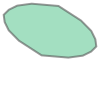

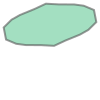

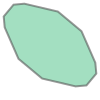

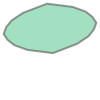

In [28]:
for n in range(4):
    display(cell_polygon(xy=(0, 0), n_points=20, repeat_first=False, seed=n))

### Randomised Cell Boundaries

Here we create a function to generate grid of cells for testing. It uses a fixed seed for reproducibility.


### A Sample 5×5 Grid


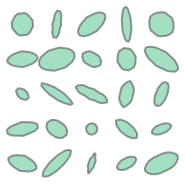

In [30]:
from shapely.geometry import MultiPolygon

MultiPolygon(polygons=list(cell_grid(size=(5, 5), spacing=35)))

# Part 1: Small Scale Benchmarking of Annotation Storage

Using the already defined data generation functions (`cell_polygon` and
`cell_grid`),  we create some simple artificial cell boundaries by
creating a circle of points, adding some noise, scaling to introduce
eccentricity, and then rotating. We use 20 points per cell, which is a
reasonably high value for cell annotation. However, this can be
adjusted.


## Appending Annotations (In-Memory & Disk I/O)

Here we test:

1. A python dictionary based in-memory store (`DictionaryStore`)
2. An SQLite database based in-memory store (`SQLiteStore`)

Both of these stores may operate in memory. The `SQLiteStore` may also
be backed by an on-disk file for datasets which are too large to fit in
memory. The `DictionaryStore` class can serialise/deserialise itself
to/from disk in a line delimited GeoJSON format (each line seperated
by `\n` is a valid GeoJSON object)

In [7]:
# Convert to annotations (a dataclass pairing a geometry and (optional)
# key-value properties)
# Run time: ~2s
annotations = [
    Annotation(polygon) for polygon in cell_grid(size=(100, 100), spacing=35)
]

### In Memory Append

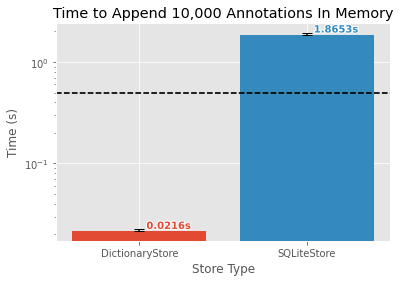

In [8]:
# Time dictionary store
dict_runs = timeit.repeat(
    "dict_store.append_many(annotations)",
    setup="dict_store = DictionaryStore()",
    globals={"DictionaryStore": DictionaryStore, "annotations": annotations},
    number=1,
    repeat=3,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "sql_store.append_many(annotations)",
    setup="sql_store = SQLiteStore()",
    globals={"SQLiteStore": SQLiteStore, "annotations": annotations},
    number=1,
    repeat=3,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Time to Append 10,000 Annotations In Memory",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.hlines(0.5, -0.5, 1.5, linestyles="dashed", color="k")
plt.xlim([-0.5, 1.5])
plt.show()

Note that inserting into the `SQLiteStore` is much slower than the
`DictionaryStore`. Appending to a `Dictionary` store simply requires
adding a memory reference to a dictionary. Therefore, this is a very
fast operation. On the other hand, for the `SQLiteStore`, the insertion
is slower because the data must be serialised for the database and the
R-Tree spatial index must also be updated. Updating the index is a
relatively expensive operation. However, this spatial index allows for
very fast queries of a very large set of annotations within a set of
spatial bounds.

Insertion is typically only performed once for each
annotation, whereas queries may be performed many times on the
annotation set. Therefore, it makes sense to trade a more expensive
insertion for fast queries as the cost of insertion will be amortised
over a number of queries on the data. Additionally, data may be written
to the database from multiple threads or subprocesses (so long as a new
instance of `SQLiteStore` is created for each thread or subprocess to
attach to a database on disk) thus freeing up the main thread.

For comparison, we also compare bulk insertion plus seralising to disk
as line-delimited GeoJSON from the `DictionaryStore` as this is the
default serialisation to disk method (`DictionaryStore.dump(file_path`).

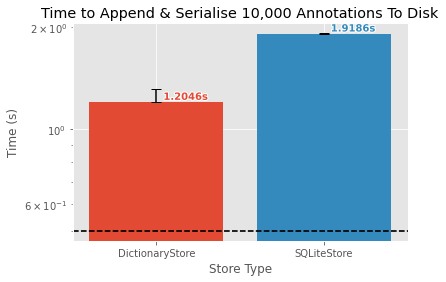

In [9]:
setup = "fp.truncate(0)\n" "store = Store(fp)"  # Clear the file

# Time dictionary store
with tempfile.NamedTemporaryFile("w+") as fp:
    dict_runs = timeit.repeat(
        ("store.append_many(annotations)\n" "store.commit()"),
        setup=setup,
        globals={"Store": DictionaryStore, "annotations": annotations, "fp": fp},
        number=1,
        repeat=3,
    )

# Time SQLite store
with tempfile.NamedTemporaryFile("w+b") as fp:
    sqlite_runs = timeit.repeat(
        ("store.append_many(annotations)\n" "store.commit()"),
        setup=setup,
        globals={"Store": SQLiteStore, "annotations": annotations, "fp": fp},
        number=1,
        repeat=3,
    )

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Time to Append & Serialise 10,000 Annotations To Disk",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.hlines(0.5, -0.5, 1.5, linestyles="dashed", color="k")
plt.xlim([-0.5, 1.5])
plt.show()

Here we can see that when we include the serialisation to disk in the
benchmark, the time to insert is much more similar.

## Box Query

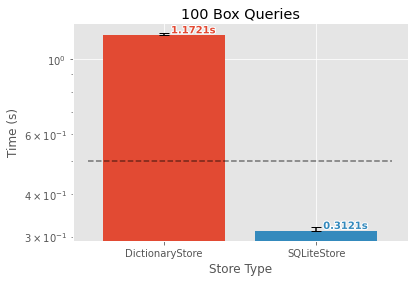

In [10]:
# One time Setup
dict_store = DictionaryStore()
sql_store = SQLiteStore()
dict_store.append_many(annotations)
sql_store.append_many(annotations)

np.random.seed(123)
boxes = [
    Polygon.from_bounds(x, y, 128, 128)
    for x, y in np.random.randint(0, 1000, size=(100, 2))
]
stmt = "for box in boxes:\n" "    _ = store.query(box)"

# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={"store": dict_store, "boxes": boxes},
    number=1,
    repeat=10,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={"store": sql_store, "boxes": boxes},
    number=1,
    repeat=10,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="100 Box Queries",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

Here we can see that the `SQLiteStore` is a bit faster. Addtionally,
difference in performance is more pronounced when there are more
annotations (as we will see later in this notebook) in the store or when
just returning keys:

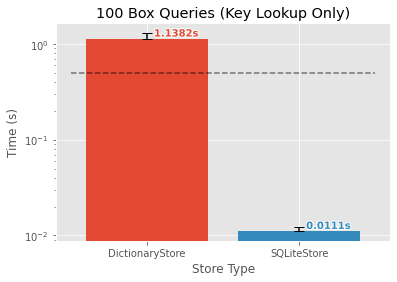

In [11]:
# One time Setup
dict_store = DictionaryStore()
sql_store = SQLiteStore()
dict_store.append_many(annotations)
sql_store.append_many(annotations)

np.random.seed(123)
boxes = [
    Polygon.from_bounds(x, y, 128, 128)
    for x, y in np.random.randint(0, 1000, size=(100, 2))
]
stmt = "for box in boxes:\n" "    _ = store.iquery(box)"  # Just return the keys (uuids)

# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={"store": dict_store, "boxes": boxes},
    number=1,
    repeat=10,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={"store": sql_store, "boxes": boxes},
    number=1,
    repeat=10,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="100 Box Queries (Key Lookup Only)",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

## Polygon Query

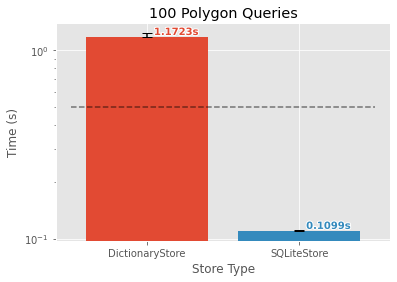

In [12]:
# One time Setup
dict_store = DictionaryStore()
sql_store = SQLiteStore()
dict_store.append_many(annotations)
sql_store.append_many(annotations)

np.random.seed(123)
query_polygons = [
    Polygon(
        [
            (x, y),
            (x + 128, y),
            (x + 128, y + 128),
            (x, y),
        ]
    )
    for x, y in np.random.randint(0, 1000, size=(100, 2))
]
stmt = "for polygon in query_polygons:\n" "    _ = store.query(polygon)"

# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={"store": dict_store, "query_polygons": query_polygons},
    number=1,
    repeat=10,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={"store": sql_store, "query_polygons": query_polygons},
    number=1,
    repeat=10,
)

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="100 Polygon Queries",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

Here we can see that performing queries within a polygon region is about
10x faster with the `SQLiteStore` than with the `DictionaryStore`.

## Predicate Query

Here we query the whole annotation region but with a predicate to
select only annotations with the class label of 0. We also,
demonstrate how creating a database index can dramatically improve
the performance of queries.

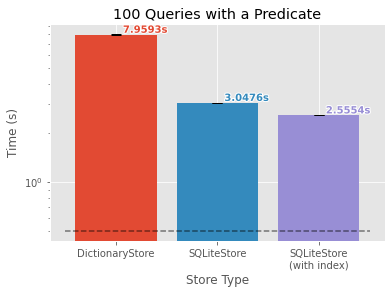

In [13]:
# Setup
labelled_annotations = copy.deepcopy(annotations)
for n, annotation in enumerate(labelled_annotations):
    annotation.properties["class"] = n % 10
    annotation.properties["vector"] = np.random.randint(1, 4, 10).tolist()

predicate = "(props['class'] == ?) & (3 in props['vector'])"
classes = np.random.randint(0, 10, size=100)
stmt = "for n in classes:\n" "    store.query(where=predicate.replace('?', str(n)))"

dict_store = DictionaryStore()
sql_store = SQLiteStore()

dict_store.append_many(labelled_annotations)
sql_store.append_many(labelled_annotations)


# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={"store": dict_store, "predicate": predicate, "classes": classes},
    number=1,
    repeat=10,
)
dict_result = dict_store.query(where=predicate.replace("?", "0"))

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={"store": sql_store, "predicate": predicate, "classes": classes},
    number=1,
    repeat=10,
)
sql_result = sql_store.query(where=predicate.replace("?", "0"))


# Add an index
# Note: Indexes may not always speed up the query (sometimes they can
# actually slow it down), test to make sure.
sql_store.create_index("class_lookup", "props['class']")
sql_store.create_index("has_3", "3 in props['vector']")

# Time SQLite store again
sqlite_index_runs = timeit.repeat(
    stmt,
    globals={"store": sql_store, "predicate": predicate, "classes": classes},
    number=1,
    repeat=10,
)
sql_index_result = sql_store.query(where=predicate.replace("?", "0"))

# # Validate the results against each other
# for a, b, c in zip(dict_result, sql_result, sql_index_result):
#     assert a.geometry == b.geometry == c.geometry

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs, sqlite_index_runs],
    title="100 Queries with a Predicate",
    tick_label=["DictionaryStore", "SQLiteStore", "SQLiteStore\n(with index)"],
)
plt.show()

### Polygon & Predicate Query

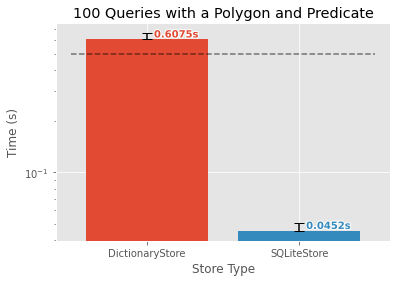

In [14]:
# Setup
labelled_annotations = copy.deepcopy(annotations)
for n, annotation in enumerate(labelled_annotations):
    annotation.properties["class"] = n % 10

predicate = "props['class'] == "
classes = np.random.randint(0, 10, size=50)
query_polygons = [
    Polygon(
        [
            (x, y),
            (x + 128, y),
            (x + 128, y + 128),
            (x, y),
        ]
    )
    for x, y in np.random.randint(0, 1000, size=(100, 2))
]
stmt = (
    "for n, poly in zip(classes, query_polygons):\n"
    "    store.query(poly, where=predicate + str(n))"
)

dict_store = DictionaryStore()
sql_store = SQLiteStore()

dict_store.append_many(labelled_annotations)
sql_store.append_many(labelled_annotations)


# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={
        "store": dict_store,
        "predicate": predicate,
        "classes": classes,
        "query_polygons": query_polygons,
    },
    number=1,
    repeat=10,
)
dict_result = dict_store.query(query_polygons[0], where=predicate + "0")

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={
        "store": sql_store,
        "predicate": predicate,
        "classes": classes,
        "query_polygons": query_polygons,
    },
    number=1,
    repeat=10,
)
sql_result = sql_store.query(query_polygons[0], where=predicate + "0")


# Check that the set difference of bounding boxes is empty i.e. all sets
# of results contain polygons which produce the same set of bounding
# boxes. This avoids being tripped up by slight varations in order or
# coordinate order between the results.
dict_set = set(x.geometry.bounds for x in dict_result)
sql_set = set(x.geometry.bounds for x in sql_result)
assert len(dict_set.difference(sql_set)) == 0

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="100 Queries with a Polygon and Predicate",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

### Complex Predicate Query

Here we slightly increase the complexity of the predicate to show how
the complexity of a predicate can dramatically affect the performance
when handling many annotations.

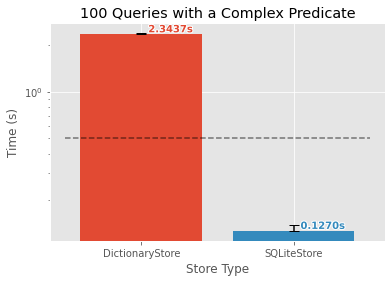

In [15]:
# Setup
box = Polygon.from_bounds(0, 0, 1024, 1024)
labelled_annotations = copy.deepcopy(annotations)
for n, annotation in enumerate(labelled_annotations):
    annotation.properties["class"] = n % 4
    annotation.properties["n"] = n

predicate = "(props['n'] > 1000) & (props['n'] % 4 == 0) & (props['class'] == "
targets = np.random.randint(0, 4, size=100)
stmt = "for n in targets:\n" "    store.query(box, where=predicate + str(n) + ')')"

dict_store = DictionaryStore()
sql_store = SQLiteStore()

dict_store.append_many(labelled_annotations)
sql_store.append_many(labelled_annotations)


# Time dictionary store
dict_runs = timeit.repeat(
    stmt,
    globals={
        "store": dict_store,
        "predicate": predicate,
        "targets": targets,
        "box": box,
    },
    number=1,
    repeat=10,
)
dict_result = dict_store.query(box, where=predicate + "0)")

# Time SQLite store
sqlite_runs = timeit.repeat(
    stmt,
    globals={
        "store": sql_store,
        "predicate": predicate,
        "targets": targets,
        "box": box,
    },
    number=1,
    repeat=10,
)
sql_result = sql_store.query(box, where=predicate + "0)")


# Check that the set difference of bounding boxes is empty i.e. all sets
# of results contain polygons which produce the same set of bounding
# boxes. This avoids being tripped up by slight varations in order or
# coordinate order between the results.
dict_set = set(x.geometry.bounds for x in dict_result)
sql_set = set(x.geometry.bounds for x in sql_result)

assert len(dict_set.difference(sql_set)) == 0

# Plot the results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="100 Queries with a Complex Predicate",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

# Part 2: Large Scale Dataset Benchmarking

Here we generate some sets of anntations with five million items each
(in a 2237 x 2237 grid). One is a set of points, the other a set of
generated cell boundaries.

The code to generate and write out the annotations to various formats is
included in the following cells. However, some of these take a very long
time to run. A pre-generated dataset is downloaded and then read from
disk instead to save time. However, you may uncomment the generation
code to replicate the original.


## 2.1: Points Dataset

Here we generate a simple points data in a grid. The grid is 2237 x 2237
and contains over 5 million points. We also write this to disk in
various formats. Some formats take a long time and are commented out. A
summary of times for a consumer laptop are shown in a table at the end.

In [16]:
# Generate some points with a little noise
# Run time: ~2.6s
points = np.array(
    [[x, y] for x in np.linspace(0, 75_000, 2237) for y in np.linspace(0, 75_000, 2237)]
)

# Add some noise between -1 and 1
np.random.seed(42)
points += np.random.uniform(-1, 1, size=(2237**2, 2))

### Writing To Disk

In [17]:
# Save as a simple Numpy array (.npy)
# Run time: ~0.1s
np.save("points.npy", points)

In [18]:
# Save as compressed NumPy archive (.npz)
# Run time: ~3.3s
np.savez_compressed("points.npz", points)

Note that the above numpy format is missing the keys (UUIDs) of each point.
This may not be required in all cases. However, for the sake of comparison
we also generate a NumPy archive with keys included. We store the UUIDs
as integers to save space and for a fair comparison where the optimal
storage method is used in each case. Note however that UUIDs are too
large to be a standard C type and therefore are stored as an object
array.

In [19]:
# Run time: ~7s
keys = np.array([uuid.uuid4().int for _ in range(len(points))])

In [20]:
# Save in NumPy format (.npz)
# Run time: ~0.5s
# Generate some UUIDs as keys
np.savez("uuid_points.npz", keys=keys, coords=points)

In [21]:
# Save in compressed (zip) NumPy format (.npz)
# Run time: ~30s
np.savez_compressed("uuid_points_compressed.npz", keys=keys, coords=points)

In [22]:
# Write the points dataset files to disk
from shapely.geometry import Point

from tiatoolbox.annotation.storage import Annotation

# # Write to SQLite with SQLiteStore
# # Run time: ~6m 20s
# points_store = SQLiteStore("points.db")
# _ = points_store.append_many(annotations=(Annotation(Point(x, y)) for x, y in points))

# Load pre-generated
# Run time: ~0.4s
from tiatoolbox.annotation.storage import SQLiteStore

points_sqlite_store = SQLiteStore("points.db")

In [23]:
# Load a DictionaryStore into memory by copying from the SQLiteStore
# Run time: ~1m 30s
points_dict_store = DictionaryStore(Path("points.ndjson"))
for key, value in points_sqlite_store.items():
    points_dict_store[key] = value

In [24]:
# Save as GeoJSON
# Run time: ~2m 30s
points_sqlite_store.to_geojson("points.geojson")

In [25]:
# Save as ndjson
# Run time: ~2m
# Spec: https://github.com/ndjson/ndjson-spec
points_sqlite_store.to_ndjson("points.ndjson")

### Points Dataset Statistics Summary

| Format                         | Write Time |  Size  |
|-------------------------------:|-----------:|-------:|
| SQLiteStore (.db)              |     6m 20s |  893MB |
| ndjson                         |     1m 23s | 667 MB |
| GeoJSON                        |     1m 42s | 500 MB |
| NumPy + UUID (.npz)            |       0.5s | 165 MB |
| NumPy + UUID Compressed (.npz) |        31s | 136 MB |
| NumPy (.npy)                   |       0.1s |  76 MB |
| NumPy Compressed (.npz)        |       3.3s |  66 MB |


Note that the points SQLite database is significantly larger than the
NumPy arrays on disk. The numpy array is much more storage efficient
partly because there is no R Tree index or unique identifier (UUID)
stored for each point. For a more fair comparison, another NumPy archive
(.npz) is created where the keys are stored along with the coordinates.

Also note that although the compressed NumPy representation is much
smaller, it must be decompressed in memeory before it can be used. The
uncompressed versions may be memory mapped if their size exceeds the
available memory.

### Simple Box Query

Here we evaluate the performance of performing a simple box query on the
data. All points which are in the area between 128 and 256 in the x and
y coordinates are retrieved. It is assumed that the data is already in
memory for the NumPy formats. In reality this would not the be case for
the first query, all data would have to be read from disk, which is a
significan overhead. However, this cost is amortised across many
queries. To ensure the fairest possible comparison, it is assumed that
many queries will be performed, and that this data loading cost in
negligable.

In [26]:
box = Polygon.from_bounds(128, 128, 256, 256)

# Time numpy
numpy_runs = timeit.repeat(
    (
        "where = np.all(["
        "points[:, 0] > 128,"
        "points[:, 0] < 256,"
        "points[:, 1] > 128,"
        "points[:, 1] < 256"
        "], 0)\n"
        "uuids = keys[where]\n"
        "result = points[where]\n"
    ),
    globals={"keys": keys, "points": points, "np": np},
    number=1,
    repeat=10,
)

# Time SQLiteStore
sqlite_runs = timeit.repeat(
    "store.query(box)",
    globals={"store": points_sqlite_store, "box": box},
    number=1,
    repeat=10,
)

# Time DictionaryStore
dict_runs = timeit.repeat(
    "store.query(box)",
    globals={"store": points_dict_store, "box": box},
    number=1,
    repeat=10,
)

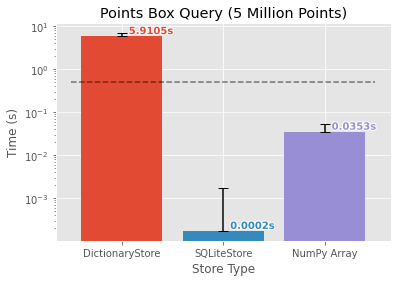

In [27]:
plot_results(
    experiments=[dict_runs, sqlite_runs, numpy_runs],
    title="Points Box Query (5 Million Points)",
    tick_label=["DictionaryStore", "SQLiteStore", "NumPy Array"],
)
plt.show()

Although the NumPy array is very space efficient on disk, it is not as
fast to query as the `SQLiteStore`. The `SQLiteStore` is likely faster
due to the use of the R tree index. Furthermore, the method used to
store the points in a NumPy array is limited in that it does not use
UUIDs, which makes merging two datasets more difficult as the indexes of
points no longer uniquely identify them. Additionally, only homogeneous
data such as two-dimentional coordinates can be practically stored in
this way. If the user would like to store variable length data
structures such as polygons, or even mix data types by storing both
points and polygons, then using raw NumPy arrays in this way can become
cumbersome and begins to offer little benefit in terms of storage
efficient or query performance.

### Polygon Query

In [28]:
big_triangle = Polygon(
    shell=[
        (1024, 1024),
        (1024, 4096),
        (4096, 4096),
        (1024, 1024),
    ]
)

# Time SQLiteStore
sqlite_runs = timeit.repeat(
    "store.query(polygon)",
    globals={"store": points_sqlite_store, "polygon": big_triangle},
    number=1,
    repeat=10,
)

# Time DictionaryStore
dict_runs = timeit.repeat(
    "store.query(polygon)",
    globals={"store": points_dict_store, "polygon": big_triangle},
    number=1,
    repeat=10,
)

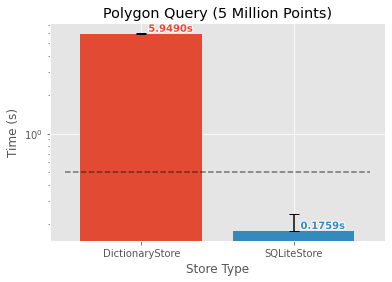

In [29]:
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Polygon Query (5 Million Points)",
    tick_label=["DictionaryStore", "SQLiteStore"],
)
plt.show()

## 2.2: Cell Boundary Polygons Dataset

Here we generate a much larger and more complex polygon dataset. This
consistes of a grid of over 5 million generated cell boundary like
polygons.

In [30]:
# Download the pre-generated data (7.1GB),
# uncomment below to regenerate it instead
! wget -nc https://tiatoolbox.dcs.warwick.ac.uk/benchmarks/annotation/cells.pickle

zsh:1: command not found: wget


In [31]:
# Load pre-generated pickle
# Run time: ~2m
with open("cells.pickle", "rb") as fh:
    cell_polygons = pickle.load(fh)

In [32]:
# Generate a grid of 5 million cell boundary polygons (2237 x 2237)
# Run time: ~12m

# import random
# random.seed(42)

# cell_polygons = [
#     Annotation(geometry=polygon, properties={"class": random.randint(0, 4)})
#     for polygon
#     in cell_grid(size=(2237, 2237), spacing=35)
# ]

In [33]:
# Download the pre-generated data (7.2GB),
# uncomment below to regenerate it instead
! wget -nc https://tiatoolbox.dcs.warwick.ac.uk/benchmarks/annotation/cells.db

zsh:1: command not found: wget


In [34]:
# Load the pre-generated sqlite db
# Run time: ~0.5s
from tiatoolbox.annotation.storage import SQLiteStore

cell_sqlite_store = SQLiteStore("cells.db")

In [35]:
# Write to a SQLiteStore on disk (SSD)
# Run time: ~44m

# cell_store = SQLiteStore("cells.db")
# _ = cell_store.append_many(annotations=cell_polygons)

In [36]:
# Create a copy as an in memory DictionaryStore
# Run time: ~4m
cell_dict_store = DictionaryStore()
for key, value in tqdm(  # Show a nice progress bar
    cell_sqlite_store.items(),
    total=len(cell_sqlite_store),
    leave=False,
    position=0,
):
    cell_dict_store[key] = value

In [37]:
# Load pre-generated (7.2GB)
# uncomment the cell below to regenerate it instead
! wget -nc https://tiatoolbox.dcs.warwick.ac.uk/benchmarks/annotation/cells.npy

zsh:1: command not found: wget


In [38]:
# Load pre-generated npy
# Run time: ~1 min 30s
cell_polygons_np = np.load("cells.npy", allow_pickle=True)

In [39]:
# Create an Nx4 index of (xmin, ymin, xmax, ymax) as a simple spatial
# index to dramatically speed up the numpy query.
# Run time: ~35s
min_max_index = np.array(
    [(*np.min(coords, 0), *np.max(coords, 0)) for coords in cell_polygons_np]
)

### Write To Other Formats For Comparison (Optional)

In [40]:
# Write to line delimited JSON (ndjson)
# Run time: ~120m

# cell_store.to_ndjson("cells.ndjson")

In [41]:
# Write to GeoJSON
# Run time: ~240m

# cell_store.to_geojson("cells.geojson")

In [42]:
# Write as a pickle
# Run time: ~10.5m
# import pickle

# with open("cells.pickle", "wb") as f:
#     pickle.dump(cell_polygons, f)

In [43]:
# Zstandard compression of ndjson to demonstrate how well it compresses.
# Gzip may also be used but is slower to compress.
# Run time: ~1.5m
# ! zstd -k cells.ndjson -o cells.ndjson.zstd

In [44]:
# Generate a copy with shapely polygons converted to numpy arrays
# Run time: ~4m

# cell_polygons_np = [
#     np.array(x.geometry.exterior.coords)
#     if not isinstance(x.geometry, MultiPolygon)
#     else np.array(x.geometry[0].exterior.coords)
#     for x in cell_polygons
# ]

In [45]:
# Write as numpy object array (similar to writing out with pickle),
# Numpy cannot handle ragged arrays and therfore dtype must be object.
# Run time: ~35m
# np.save("cells.npy", np.asanyarray(cell_polygons_np, dtype=object))

In [46]:
# Create UUIDs, and get the class labels for each cell boundary
# Run time: ~6s
# _uuids = [str(uuid.uuid4) for _ in cell_polygons]
# _cls = [x.properties["class"] for x in cell_polygons]

In [47]:
# Write as NumPy archive (.npz) with uuid and min_max_index
# Run time: ~60m
# np.savez(
#     "cells.npz",
#     uuids=_uuids,
#     polygons=cell_polygons_np,
#     min_max_index=min_max_index,
#     cls=_cls,
# )

# del _uuids, _cls

### Time To Write Summary Statistics

The following is a summary of the time required to write each format to
disk and the total disk space occupied by the final output.

Note that some of these formats, such as GeoJSON compress well with
schemes such as gzip and zstd, reducing the disk space by approximately
half. Statistics for zstd compressed data is also reported below. It
should be noted that the data must be decompressed to be usable.
However, for gzip and zstd, this may be done in a streaming fashion from
disk.

|       Format      | Write Time  |   Size  |
|------------------:|------------:|--------:|
| GeoJSON           |  241m 23.2s |  18 GB  |
| ndjson            |  121m 5.4s  |  17 GB  |
| NumPy (.npz)      |    59mm 47s |  7.9 GB |
| ndjson zstd       |  122m 31.8s |  7.5 GB |
| SQLiteStore (.db) |   44m 36.1s |  7.2 GB |
| NumPy (.npy)      |   35m 56.9s |  7.2 GB |
| pickle            |   10m 20.2s |  7.1 GB |


### Box Query

In [48]:
xmin, ymin, xmax, ymax = 128, 12, 256, 256
box = Polygon.from_bounds(xmin, ymin, xmax, ymax)


# Time DictionaryStore
dict_runs = timeit.repeat(
    "store.query(box)",
    globals={"store": cell_dict_store, "box": box},
    number=1,
    repeat=3,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "store.query(box)",
    globals={"store": cell_sqlite_store, "box": box},
    number=1,
    repeat=3,
)

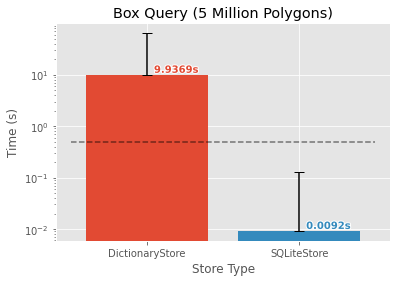

In [49]:
# Plot results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Box Query (5 Million Polygons)",
    tick_label=[
        "DictionaryStore",
        "SQLiteStore",
    ],
)
plt.show()

### Polygon Query

In [50]:
big_triangle = Polygon(
    shell=[
        (1024, 1024),
        (1024, 4096),
        (4096, 4096),
        (1024, 1024),
    ]
)


# Time DictionaryStore
dict_runs = timeit.repeat(
    "store.query(polygon)",
    globals={"store": cell_dict_store, "polygon": big_triangle},
    number=1,
    repeat=3,
)

# Time SQLite store
sqlite_runs = timeit.repeat(
    "store.query(polygon)",
    globals={"store": cell_sqlite_store, "polygon": big_triangle},
    number=1,
    repeat=3,
)

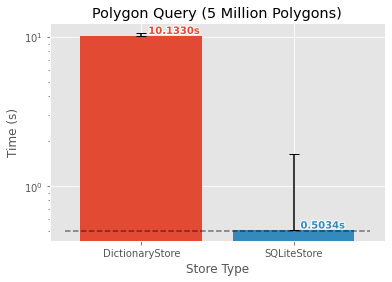

In [51]:
# Plot results
plot_results(
    experiments=[dict_runs, sqlite_runs],
    title="Polygon Query (5 Million Polygons)",
    tick_label=[
        "DictionaryStore",
        "SQLiteStore",
    ],
)
plt.show()

### Predicate Query

In [57]:
xmin, ymin, xmax, ymax = 128, 12, 256, 256
box = Polygon.from_bounds(xmin, ymin, xmax, ymax)
predicate = "props['class'] == 0"

# Time DictionaryStore
dict_runs = timeit.repeat(
    "store.query(box, predicate)",
    globals={"store": cell_dict_store, "box": box, "predicate": predicate},
    number=1,
    repeat=3,
)

# Time SQLiteStore
sqlite_runs = timeit.repeat(
    "store.query(box, where=predicate)",
    globals={"store": cell_sqlite_store, "box": box, "predicate": predicate},
    number=1,
    repeat=3,
)

np_stmt = f"""
polygons = [
    polygon
    for polygon in tqdm(cell_polygons_np)
    if np.all([np.max(polygon, 0) >= ({xmin}, {ymin}), np.min(polygon, 0) <= ({xmax}, {ymax})])
]
"""

# Time numpy
numpy_runs = timeit.repeat(
    np_stmt,
    globals={"cell_polygons_np": cell_polygons_np, "np": np, "tqdm": lambda x: x},
    number=1,
    repeat=3,
)

# Time shapely
shapely_runs = timeit.repeat(
    "polygons = [box.intersects(ann.geometry) for ann in cell_polygons]",
    globals={"box": box, "cell_polygons": cell_polygons},
    number=1,
    repeat=3,
)

# Time box indexed numpy
numpy_index_runs = timeit.repeat(
    "in_box = np.all(min_max_index[:, :2] <= (xmax, ymax), 1) & np.all(min_max_index[:, 2:] >= (xmin, ymin), 1)\n"
    "polygons = [p for p, w in zip(cell_polygons, in_box) if w]",
    globals={
        "min_max_index": min_max_index,
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
        "np": np,
        "cell_polygons": cell_polygons,
    },
    number=1,
    repeat=3,
)

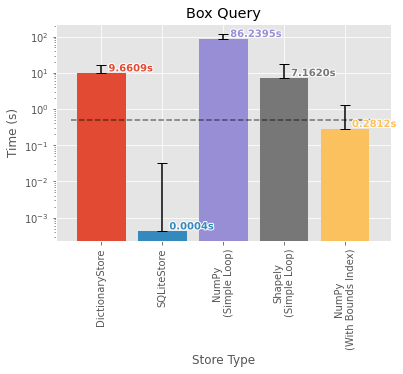

In [58]:
# Plot results
plot_results(
    experiments=[dict_runs, sqlite_runs, numpy_runs, shapely_runs, numpy_index_runs],
    title="Box Query",
    tick_label=[
        "DictionaryStore",
        "SQLiteStore",
        "NumPy\n(Simple Loop)",
        "Shapely\n(Simple Loop)",
        "NumPy\n(With Bounds Index)",
    ],
)
plt.xticks(rotation=90)
plt.show()

### Size vs Approximate Lower Bound

Here we calculate an estimated lower bound on file size by finding the
the Shannon entropy of each file. This tells us the theoretical minimum
number of bits per byte. The lowest lower bound is then used as an
estimate of the minimum file size possible to store the annotation data.

In [54]:
import numpy as np
from typing import Tuple
from pathlib import Path

from tqdm.auto import tqdm


def human_readible_bytes(byte_count: int) -> Tuple[int, str]:
    """Convert bytes to human readble size and suffix."""
    for suffix in ["B", "KB", "MB", "GB", "TB"]:
        if byte_count < 1024:
            return byte_count, suffix
        byte_count /= 1024
    return byte_count, "PB"


def shannon_entropy(
    fp: Path,
    sample_size: int = 1e9,  # 1GiB
    stride: int = 7,
    skip: int = 1e5,  # 100KiB
) -> float:
    """Calculate the Shannon entropy of a file from a sample.

    The first `skip` bytes are skipped to avoid sampling low entropy
    (highly ordered) parts which commonly occur at the beginning e.g.
    headers.

    Args:
        fp: File path to calculate entropy of.
        sample_size: Number of bytes to sample from the file.
        stride: Number of bytes to skip between samples.
        skip: Number of bytes to skip before sampling.
    """
    npmmap = np.memmap(Path(fp), dtype=np.uint8, mode="r")
    values, counts = np.unique(
        npmmap[int(skip) : int(skip + (sample_size * stride)) : int(stride)],
        return_counts=True,
    )
    total = np.sum(counts)
    frequencies = {v: 0 for v in range(256)}
    for v, x in zip(values, counts):
        frequencies[v] = x / total
    frequency_array = np.array(list(frequencies.values()))
    epsilon = 1e-16
    return -np.sum(frequency_array * np.log2(frequency_array + epsilon))


# Find the min across all of the representations for the lowest lower
# bound.
bytes_lower_bounds = {
    path: (
        shannon_entropy(Path(path)) / 8 * len(np.memmap(path, dtype=np.uint8, mode="r"))
    )
    for path in tqdm(list(Path("./").glob("cells.*")), position=0, leave=False)
}

lowest_bytes_lower_bound = min(bytes_lower_bounds.values())

size, suffix = human_readible_bytes(lowest_bytes_lower_bound)
print(f"Approximate Lower Bound Size: {size:.2f} {suffix}")

Approximate Lower Bound Size: 6.67 GB


The SQLite representation (7.2GB) appears to be quite compact and not too far
from our approximate lower bound on size (6.4GB).

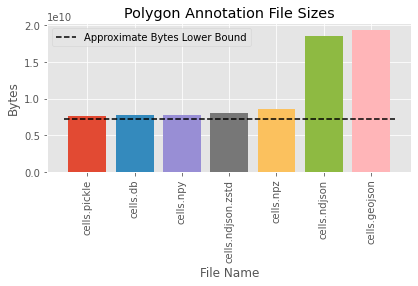

In [60]:
from pathlib import Path

# Get file sizes
file_sizes = {path: path.stat().st_size for path in list(Path("./").glob("cells.*"))}

# Sort by size
file_sizes = {k: v for k, v in sorted(file_sizes.items(), key=lambda x: x[1])}

# Plot
plt.bar(
    x=range(len(file_sizes)),
    height=file_sizes.values(),
    tick_label=[p.name for p in file_sizes],
    color=[f"C{i}" for i in range(len(file_sizes))],
)
plt.xlabel("File Name")
plt.ylabel("Bytes")
plt.xticks(rotation=90)
plt.hlines(
    y=lowest_bytes_lower_bound,
    xmin=-0.5,
    xmax=len(file_sizes) - 0.5,
    linestyles="dashed",
    color="black",
    label="Approximate Bytes Lower Bound",
)
plt.legend()
plt.tight_layout()
plt.title("Polygon Annotation File Sizes")
plt.show()